### Import the libraries

In [0]:
from pathlib import Path
from keras.datasets import cifar10
from scipy import ndimage
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

### Data Augmentation function

In [0]:
def augment_dataset(train_images, train_labels, level=12):
    # Flip
    if level >= 2:
        train_images = np.concatenate((train_images, [np.flip(x, axis=1) for x in train_images]))
        train_labels = np.append(train_labels, train_labels)

    # Rotations
    if level >= 6:
        rot15 = [ndimage.interpolation.rotate(x, 15, reshape=False, mode="nearest") for x in train_images]
        rot345 = [ndimage.interpolation.rotate(x, 345, reshape=False, mode="nearest") for x in train_images]
        train_images = np.concatenate((train_images, rot15))
        train_images = np.concatenate((train_images, rot345))
        train_labels = np.append(np.append(train_labels, train_labels), train_labels)

    # Noise
    if level == 12:
        train_images = np.concatenate((train_images, np.random.normal(train_images, 0.03)))
        train_labels = np.append(train_labels, train_labels)

    return train_images, train_labels

### Learning rate scheduler to define a custom learning curve

In [0]:
# Learning rate schedule, change according to training progress
def learning_rate_scheduler(epoch):
    if epoch < 150:
        return 0.001
    if 150 <= epoch < 250:
        return 0.0001
    else:
        return 0.00001

### Function to plot confusion matrix
Source: Scikit-learn documentation

In [0]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Hyperparameters

In [0]:
num_classes = 10
epochs = 350
num_checkpoints = 10
learning_rate = 0.001 #-> To be defined inside the learning rate scheduler
batch_size = 500
model_name = "cifar10_resnet18"
verbosity = 2
data_augmentation = False
# Levels: 2 Include Flip, 6 Include Rotation, 12 Include Noise
augmentation_level = 12
training_active = True
print_confusion_matrix = True
print_training_graphs = True
# Dictionary of common parameters used in convolutional layers
params_conv2d = {
        "padding": "SAME",
        "activation": keras.activations.elu
        # 'kernel_regularizer': keras.regularizers.l2(0.01)
}

### Loading, preprocessing and data augmentation

In [0]:
# #Load data
# (train_images, train_labels) = np.load("data/trnImage.npy"), np.load("data/trnLabel.npy")
# (test_images, test_labels) = np.load("data/tstImage.npy"), np.load("data/tstLabel.npy")
(train_images,train_labels),(test_images,test_labels) = cifar10.load_data()



# #Preprocess data
# train_images = np.subtract(np.moveaxis(train_images, -1, 0).flatten(), 1)
# test_images = np.subtract(np.moveaxis(test_images, -1, 0).flatten(), 1)

# Dataset augmentation
if data_augmentation:
    train_images, train_labels = augment_dataset(train_images, train_labels, augmentation_level)

# Conversion of labels to one-hot arrays
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

### Define the neural network structure

In [0]:
# Input tensor
x = keras.Input((32, 32, 3))

# conv_1
conv1 = keras.layers.Conv2D(filters=32, kernel_size=7, strides=1, **params_conv2d)(x)
conv1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv1)

# conv_2_x
max_pool = keras.layers.MaxPool2D(padding="SAME")(conv1)
conv2_1 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, **params_conv2d)(max_pool)
conv2_1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv2_1)
conv2_2 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, **params_conv2d)(conv2_1)
conv2_2 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv2_2)
skip2_1 = keras.layers.BatchNormalization()(keras.layers.add([max_pool, conv2_2]))

conv2_3 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, **params_conv2d)(conv2_2)
conv2_3 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv2_3)
conv2_4 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, **params_conv2d)(conv2_3)
conv2_4 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv2_4)

resize2 = keras.layers.Conv2D(filters=32, kernel_size=1, strides=2, padding="SAME")(skip2_1)
skip2_2 = keras.layers.BatchNormalization()(keras.layers.add([resize2, conv2_4]))

# conv_3_x
conv3_1 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, **params_conv2d)(skip2_2)
conv3_1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv3_1)
conv3_2 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, **params_conv2d)(conv3_1)
conv3_2 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv3_2)

resize3_1 = keras.layers.Conv2D(filters=64, kernel_size=1, strides=1, padding="SAME")(skip2_2)
skip3_1 = keras.layers.BatchNormalization()(keras.layers.add([resize3_1, conv3_2]))

conv3_3 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, **params_conv2d)(skip3_1)
conv3_3 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv3_3)
conv3_4 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, **params_conv2d)(conv3_3)
conv3_4 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv3_4)

resize3_2 = keras.layers.Conv2D(filters=64, kernel_size=1, strides=2, padding="SAME")(skip3_1)
skip3_2 = keras.layers.BatchNormalization()(keras.layers.add([resize3_2, conv3_4]))

# conv_4_x
conv4_1 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, **params_conv2d)(skip3_2)
conv4_1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv4_1)
conv4_2 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, **params_conv2d)(conv4_1)
conv4_2 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv4_2)

resize4_1 = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1, padding="SAME")(skip3_2)
skip4_1 = keras.layers.BatchNormalization()(keras.layers.add([resize4_1, conv4_2]))

conv4_3 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, **params_conv2d)(skip4_1)
conv4_3 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv4_3)
conv4_4 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, **params_conv2d)(conv4_3)
conv4_4 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv4_4)

resize4_2 = keras.layers.Conv2D(filters=128, kernel_size=1, strides=2, padding="SAME")(skip4_1)
skip4_2 = keras.layers.BatchNormalization()(keras.layers.add([resize4_2, conv4_4]))

# conv_5_x
conv5_1 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, **params_conv2d)(skip4_2)
conv5_1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv5_1)
conv5_2 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, **params_conv2d)(conv5_1)
conv5_2 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv5_2)

resize5_1 = keras.layers.Conv2D(filters=256, kernel_size=1, strides=1, padding="SAME")(skip4_2)
skip5_1 = keras.layers.BatchNormalization()(keras.layers.add([resize5_1, conv5_2]))

conv5_3 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, **params_conv2d)(skip5_1)
conv5_3 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv5_3)
conv5_4 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, **params_conv2d)(conv5_3)
conv5_4 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv5_4)

resize5_2 = keras.layers.Conv2D(filters=256, kernel_size=1, strides=1, **params_conv2d)(skip5_1)
skip5_2 = keras.layers.BatchNormalization()(keras.layers.add([resize5_2, conv5_4]))

avg_pool = keras.layers.AvgPool2D(strides=2)(skip5_2)
flat = keras.layers.Flatten()(avg_pool)
dense10 = keras.layers.Dense(10)(flat)
softmax = keras.layers.Softmax()(dense10)

model = keras.Model(inputs=x, outputs=softmax)

### Compile the model and load weights if available

In [0]:
# Loading model weights if available
# if Path("models/" + model_name + '.h5').is_file():
#     print("loading weights")
#     model.load_weights("models/" + model_name + '.h5')

# Model compilation
model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])

### Define the model callbacks

In [23]:
# Training callbacks
callbacks = [keras.callbacks.LearningRateScheduler(learning_rate_scheduler, verbose=0),
             keras.callbacks.ModelCheckpoint('checkpoints/' + model_name + '.e{epoch:02d}-acc{val_categorical_accuracy:.3f}.h5',
                                             monitor='val_categorical_accuracy',
                                             verbose=0,
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='max',
                                             period=epochs//num_checkpoints)
             ]

### Train the model and plot progress and save the weights


In [24]:
if training_active:
    # Training step
    history = model.fit(train_images, train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        shuffle=True,
                        validation_data=(test_images, test_labels),
                        verbose=verbosity,
                        callbacks=callbacks)

    

Epoch 1/350
100/100 - 4s - loss: 2.5215 - categorical_accuracy: 0.1168 - top_k_categorical_accuracy: 0.5424 - val_loss: 2.3890 - val_categorical_accuracy: 0.2064 - val_top_k_categorical_accuracy: 0.6997 - lr: 0.0010
Epoch 2/350
100/100 - 4s - loss: 2.2199 - categorical_accuracy: 0.1736 - top_k_categorical_accuracy: 0.6778 - val_loss: 3.0519 - val_categorical_accuracy: 0.1137 - val_top_k_categorical_accuracy: 0.5520 - lr: 0.0010
Epoch 3/350
100/100 - 4s - loss: 2.0298 - categorical_accuracy: 0.2430 - top_k_categorical_accuracy: 0.7851 - val_loss: 1.9456 - val_categorical_accuracy: 0.2558 - val_top_k_categorical_accuracy: 0.8170 - lr: 0.0010
Epoch 4/350
100/100 - 4s - loss: 1.9426 - categorical_accuracy: 0.2746 - top_k_categorical_accuracy: 0.8169 - val_loss: 1.7781 - val_categorical_accuracy: 0.3343 - val_top_k_categorical_accuracy: 0.8701 - lr: 0.0010
Epoch 5/350
100/100 - 4s - loss: 1.8878 - categorical_accuracy: 0.2963 - top_k_categorical_accuracy: 0.8338 - val_loss: 1.7561 - val_cat

OSError: ignored

In [25]:
if training_active:
    # Training step
    history = model.fit(train_images, train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        shuffle=True,
                        validation_data=(test_images, test_labels),
                        verbose=verbosity,
                        callbacks=callbacks)

Epoch 1/350
100/100 - 4s - loss: 0.9985 - categorical_accuracy: 0.6409 - top_k_categorical_accuracy: 0.9690 - val_loss: 1.0353 - val_categorical_accuracy: 0.6344 - val_top_k_categorical_accuracy: 0.9607 - lr: 0.0010
Epoch 2/350
100/100 - 4s - loss: 1.0155 - categorical_accuracy: 0.6376 - top_k_categorical_accuracy: 0.9681 - val_loss: 1.0429 - val_categorical_accuracy: 0.6329 - val_top_k_categorical_accuracy: 0.9606 - lr: 0.0010
Epoch 3/350
100/100 - 4s - loss: 1.0248 - categorical_accuracy: 0.6322 - top_k_categorical_accuracy: 0.9679 - val_loss: 1.0436 - val_categorical_accuracy: 0.6337 - val_top_k_categorical_accuracy: 0.9587 - lr: 0.0010
Epoch 4/350
100/100 - 4s - loss: 1.0129 - categorical_accuracy: 0.6364 - top_k_categorical_accuracy: 0.9678 - val_loss: 1.0542 - val_categorical_accuracy: 0.6317 - val_top_k_categorical_accuracy: 0.9580 - lr: 0.0010
Epoch 5/350
100/100 - 4s - loss: 1.0228 - categorical_accuracy: 0.6334 - top_k_categorical_accuracy: 0.9674 - val_loss: 1.0627 - val_cat

/content


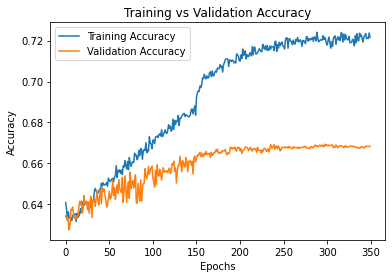

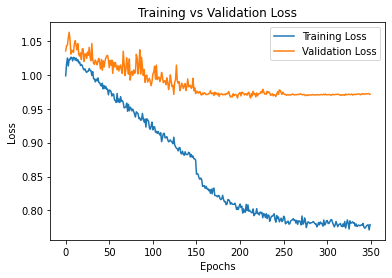

In [28]:
!pwd
model.save("/content/" + model_name + '.h5')
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

if print_training_graphs:
    # Accuracy over training time
    plt.plot(history.history['categorical_accuracy'], label="Training Accuracy")
    plt.plot(history.history['val_categorical_accuracy'], label="Validation Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Loss over training time
    plt.plot(history.history['loss'], label="Training Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

### Print the confusion matrix

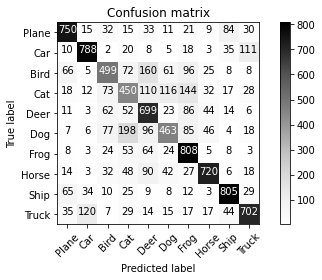

In [29]:
if print_confusion_matrix:
    predictions = np.argmax(model.predict_on_batch(test_images), 1)
    test_labels = np.argmax(test_labels, 1)

    conf_matrix = confusion_matrix(test_labels, predictions)
    plot_confusion_matrix(conf_matrix, ["Plane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"], cmap=plt.cm.Greys)
    plt.show()